# Natural Language Processing: Applications

In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
import dl2_torch as d2l
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch.nn.functional as F
from collections import Counter
import math
import random
import collections
import re
import json

d:\Anaconda3\envs\data_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Sentiment Analysis（单文本任务）

### 加载数据

d2l.DATA_HUB['aclImdb'] = (d2l.DATA_URL + 'aclImdb_v1.tar.gz',
                          '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

In [ ]:
data_dir = './data\\aclImdb'

In [ ]:
def read_imdb(data_dir, is_train):
    """Read the IMDb review dataset text sequences and labels."""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[:60])

In [ ]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

截断 填充不同长度的序列

In [ ]:
num_steps = 500  # sequence length
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

In [ ]:
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('# batches:', len(train_iter))

### 创建数据集  
- **注意** ： 我们仅使用训练集数据来构造单词表，测试集中没有在训练集中出现的字符会用 < unk > 表示  
实际制作数据集时，可以尝试使用不同的分词器，得到不同的tokens

In [ ]:
def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

In [ ]:
batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size)

### 使用 Bi-RNN 预测文本情感   
拼接 RNN 提取的首尾两个 step 最后层的输出， 作为分类层的输入

In [ ]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [ ]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
net.apply(init_weights);

#### 赋予 embedding 层权重  
从 glove 中提取训练集中存在的 embedding， 赋值给 embedding层  
nn.Embedding 层的输入为任意形状 * 的 intTensor/LongTensor， 输出为 （* ，embedding_size）

In [ ]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')  
embeds = glove_embedding[vocab.idx_to_token]
# net.embedding.weight.data.copy_(embeds)
# net.embedding.weight.requires_grad = False

In [ ]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [ ]:
print(predict_sentiment(net, vocab, 'this movie is so great'))
print(predict_sentiment(net, vocab, 'this movie is so bad'))

### 一维卷积模型  

使用 1 维度卷积提取 n-gram 的特征   

时间最大池化： 在每个通道上，对该通道内的所有所有时间步特征取最大值  


#### 一维卷积  

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411071925941.png" width='700px' >
</div>  

in_channels 需要与输入的channels 数目一致，每个一维核的shape为 (out_channels, in_channel / groups, kernel_size)

In [ ]:
m = nn.Conv1d(2, 3, 2, stride=1, bias=False)  # in_channels, out_channels, kernel_size
m.weight.data.copy_(torch.tensor([[[1, 1], [1, 1]], [[1, 1], [2, 2]], [[2, 2], [2, 2]]]))
input = torch.ones(2, 4)
output = m(input)

In [ ]:
output 

####  Max-Over-Time Pooling
在时间维度上的最大化 

In [ ]:
input = torch.arange(12, dtype=torch.float).reshape(3, 4)
nn.AdaptiveAvgPool1d(3)(input)  # 在单个维度上的Pool， 参数为kernel size

#### 模型  
- 定义多个一维卷积核，并对输入分别进行卷积操作。不同宽度的卷积核可能在不同数量的相邻标记中捕获局部特征。
- 对所有输出通道执行最大时间池化，然后将所有标量池化输出连接成一个向量。
- 将连接向量转换为输出类别，使用全连接层。可以使用 Dropout 来减少过拟合。

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411071936436.png" width='600px' >
</div>  

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

#### 训练

In [ ]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)

net.apply(init_weights);

In [ ]:
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

In [ ]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## 自然语言推理

- 自然语言推理研究是否可以从前提中推断出假设，前提和假设都是文本序列。  
- 在自然语言推理中，前提与假设之间的关系包括蕴涵、矛盾和中立。
  - 蕴涵：假设可以从前提中推断出来。
  - 矛盾：从前提中可以推断出假设的否定。
  - 中立：所有其他情况。
- 斯坦福自然语言推理（SNLI）语料库是一个流行的自然语言推理基准数据集。 

### 数据载入

In [7]:
def read_snli(data_dir, is_train):
    """Read the SNLI dataset into premises, hypotheses, and labels."""
    def extract_text(s):
        # Remove information that will not be used by us
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        # Substitute two or more consecutive whitespace with space
        s = re.sub('\\s{2,}', ' ', s)  # 这行代码用一个空格 ' ' 来替换 s 中连续两个或两个以上的空白字符。\\s 表示空白字符（包括空格、制表符、换行符等），{2,} 表示匹配两个或更多的空白字符。
        return s.strip()
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}  #  分别表示 蕴涵 矛盾 中性
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt'
                             if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

In [ ]:
data_dir = 'E:\doing\DL\divedeep\data\snli_1.0'
train_data = read_snli(data_dir, is_train=True)
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print('premise:', x0)
    print('hypothesis:', x1)
    print('label:', y)

### 加载数据集

In [ ]:
class SNLIDataset(torch.utils.data.Dataset):
    """A customized dataset to load the SNLI dataset."""
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens,
                                   min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])
        print('read ' + str(len(self.premises)) + ' examples')

    def _pad(self, lines):
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>'])
                         for line in lines])

    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        return len(self.premises)

注意的是，我们必须使用从训练集构建的词汇表作为测试集的词汇表

In [ ]:
def load_data_snli(batch_size, num_steps=50):
    """Download the SNLI dataset and return data iterators and vocabulary."""
    data_dir = 'E:\doing\DL\divedeep\data\snli_1.0'
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)  # test 使用 train_set 的vocab
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                            shuffle=False)
    return train_iter, test_iter, train_set.vocab

In [ ]:
train_iter, test_iter, vocab = load_data_snli(128, 50)
len(vocab)

### decomposable attention model
可分解注意力机制  
我们只需将一个文本序列中的标记与另一个文本序列中的每个标记对齐，反之亦然，然后比较和汇总此类信息以预测前提和假设之间的逻辑关系。  
类似于机器翻译中源句和目标句之间标记的对齐，前提和假设之间标记的对齐可以通过注意力机制巧妙地完成。  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411080859161.png" width='600px' >
</div>   

它由三个联合训练的步骤组成：关注、比较和聚合(attending, comparing, and aggregating)。

#### Attending  

使用注意力机制，我们可以将一个文本序列中的标记与另一个文本序列中的每个标记进行对齐，反之亦然。这种对齐采用加权平均的方式是软对齐，理想情况下，与要对齐的标记相关联的权重较大。  
使用注意力机制将句子对应的 token 进行组合，得到对应单词的线性对齐表示。  
现在我们更详细地描述使用注意力机制的软对齐。用 A=(a1,…,am) 和 B=(b1,…,bn) 表示前提和假设，它们的标记数分别为 m 和 n ，其中 ai,bj∈Rd （ i=1,…,m,j=1,…,n ）是一个 d 维的词向量。  
对于软对齐，我们计算注意力权重 eij∈R 如下：$ e_{ij} = f(\mathbf{a}_i)^\top f(\mathbf{b}_j), $

In [ ]:
#  MLP 获得注意力向量
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

前提对齐 token： $ \boldsymbol{\beta}_i = \sum_{j=1}^{n}\frac{\exp(e_{ij})}{ \sum_{k=1}^{n} \exp(e_{ik})} \mathbf{b}_j.$  
假设对齐 token：$ \boldsymbol{\alpha}_j = \sum_{i=1}^{m}\frac{\exp(e_{ij})}{ \sum_{k=1}^{m} \exp(e_{kj})} \mathbf{a}_i.$  
定义 Attend 类以计算假设（ beta ）与输入前提 A 的软对齐以及前提（ alpha ）与输入假设 B 的软对齐。

In [ ]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # Shape of `A`/`B`: (`batch_size`, no. of tokens in sequence A/B,
        # `embed_size`)
        # Shape of `f_A`/`f_B`: (`batch_size`, no. of tokens in sequence A/B,
        # `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)
        # Shape of `e`: (`batch_size`, no. of tokens in sequence A,
        # no. of tokens in sequence B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # Shape of `beta`: (`batch_size`, no. of tokens in sequence A,
        # `embed_size`), where sequence B is softly aligned with each token
        # (axis 1 of `beta`) in sequence A
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # Shape of `alpha`: (`batch_size`, no. of tokens in sequence B,
        # `embed_size`), where sequence A is softly aligned with each token
        # (axis 1 of `alpha`) in sequence B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

#### Comparing  
拼接对齐向量， 使用 MLP 计算比较结果

In [ ]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

#### Aggregate 
拥有两组比较向量 vA,i （ i=1,…,m ）和 vB,j （ j=1,…,n ），在最后一步，我们将汇总此类信息以推断逻辑关系。我们首先对两组数据进行求和：  
$ \mathbf{v}_A = \sum_{i=1}^{m} \mathbf{v}_{A,i}, \quad \mathbf{v}_B = \sum_{j=1}^{n}\mathbf{v}_{B,j}. $  
拼接求和后的向量，对其进行计算获得推理结果

In [ ]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # Sum up both sets of comparison vectors
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # Feed the concatenation of both summarization results into an MLP
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [ ]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)  # batch size, no sequece, embed size
        V_A, V_B = self.compare(A, B, beta, alpha)    # batch size, no sequece, num_hiddens
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

#### train

In [ ]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

In [ ]:
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

#### test

In [ ]:
def predict_snli(net, vocab, premise, hypothesis):
    """Predict the logical relationship between the premise and hypothesis."""
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), dim=1)
    return 'entailment' if label == 0 else 'contradiction' if label == 1 \
            else 'neutral'

In [ ]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

## 使用 BERT 进行 NLP 任务

### 单文本分类  
使用每个文本开头的 < cls> token输出作为该整个文本的特征提取，对其进行分类检测。  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411081005328.png" width='700px' >
</div>

### 文本对分类/回归任务
例如语义相似度分析  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411081009198.png" width='700px' >
</div>  
使用 < cls > < sep> 特殊符号拼接文本对， 通过预测 < cls> 输出/ 回归 得到结果

### 词性标注  

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411081012388.png" width='700px' >
</div>  
在每个 token 输出使用 MLP（同权重）进行分类， 得到对应的词性标注



### 下载预训练 BERT 

In [ ]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [3]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_blks, dropout, max_len, devices, data_dir):
    # Define an empty vocabulary to load the predefined vocabulary
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(
        len(vocab), num_hiddens, ffn_num_hiddens=ffn_num_hiddens, num_heads=4,
        num_blks=2, dropout=0.2, max_len=max_len)
    # Load pretrained BERT parameters
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

In [4]:
devices = d2l.try_all_gpus()
data_dir = "E:\doing\DL\divedeep\data\\bert.small.torch"
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_blks=2, dropout=0.1, max_len=512, devices=devices, data_dir=data_dir)

d:\Anaconda3\envs\data_torch\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### 定义数据集

In [5]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]
        self.t = all_premise_hypothesis_tokens
        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        # pool = multiprocessing.Pool(4)  # Use 4 worker processes
        # out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = []
        all_segments = []
        valid_lens = []
        for token_pair in all_premise_hypothesis_tokens:
            token_ids, segments, valid_len = self._mp_worker(token_pair)
            all_token_ids.append(token_ids)
            all_segments.append(segments)
            valid_lens.append(valid_len)
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # Reserve slots for '<CLS>', '<SEP>', and '<SEP>' tokens for the BERT
        # input
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [8]:
# Reduce `batch_size` if there is an out of memory error. In the original BERT
# model, `max_len` = 512
batch_size, max_len = 256, 128
data_dir = 'E:\doing\DL\divedeep\data\snli_1.0'
train_set = SNLIBERTDataset(read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_set, batch_size)

read 549367 examples
read 9824 examples


### BERT 微调  
将 BERT 输出的 < cls> 转换为 label  
在微调过程中，BERT 模型成为下游应用模型的一部分。仅与预训练损失相关的参数（包括 MaskLM 类和 NextSentencePred 类的模型参数）在微调期间不会更新。  

In [9]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder  # 仅使用已训练好的 BERT 的 encoder 去编码， 将编码所得结果输入 hidden 中， hidden层专门训练为对<cls>进行编码分类
        self.hidden = bert.hidden  # hidden 层参数会更新，其用于 nsp 任务前提取 < cls> 隐层编码
        self.output = nn.LazyLinear(3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

In [10]:
net = BERTClassifier(bert)

loss 0.507, train acc 0.797, test acc 0.788
2109.9 examples/sec on [device(type='cuda', index=0)]


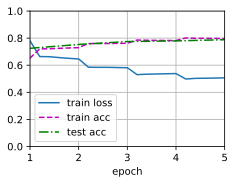

In [11]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
net(next(iter(train_iter))[0])  # 这行代码意义？
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

微调一个与原始 BERT 基础模型大小相当的更大预训练 BERT 模型，如果您的计算资源允许。在 load_pretrained_model 函数中设置参数如下：将‘bert.small’替换为‘bert.base’，将 num_hiddens=256 、 ffn_num_hiddens=512 、 num_heads=4 和 num_blks=2 的值分别增加到 768、3072、12 和 12。通过增加微调的迭代次数（以及可能调整其他超参数），您能否获得高于 0.86 的测试准确率？